<a href="https://colab.research.google.com/github/Blacknahil/Icog-tasks/blob/main/qpfs/qpfs_for_Isolet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This is a qpfs applied to Isolet data set with approximation method.

# 1. Load and preproccess the data

### imports

In [ ]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

Loading Isolet
 data set

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo, list_available_datasets


In [ ]:
#for datasets taken from UCI machine learning datasets
def to_pandas_first_files(dataset_):
  X = dataset_.data.features
  y = dataset_.data.targets

  data_f = pd.DataFrame(X)
  data_f["targets"] = y
  return data_f


#for datasests taken from Sklearn.datasets
def to_pandas_second_files(dataset_):
  X = dataset_.data
  y = dataset_.target
  data_f = pd.DataFrame(X)
  data_f["targets"] = y
  return data_f

In [ ]:
isolet = fetch_ucirepo(id=54)
isolet_df = to_pandas_first_files(isolet)
isolet_df.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute609,Attribute610,Attribute611,Attribute612,Attribute613,Attribute614,Attribute615,Attribute616,Attribute617,targets
0,-0.4394,-0.0930,0.1718,0.4620,0.6226,0.4704,0.3578,0.0478,-0.1184,-0.2310,...,0.4102,0.2052,0.3846,0.3590,0.5898,0.3334,0.6410,0.5898,-0.4872,1.0
1,-0.4348,-0.1198,0.2474,0.4036,0.5026,0.6328,0.4948,0.0338,-0.0520,-0.1302,...,0.0000,0.2954,0.2046,0.4772,0.0454,0.2046,0.4318,0.4546,-0.0910,1.0
2,-0.2330,0.2124,0.5014,0.5222,-0.3422,-0.5840,-0.7168,-0.6342,-0.8614,-0.8318,...,-0.1112,-0.0476,-0.1746,0.0318,-0.0476,0.1112,0.2540,0.1588,-0.4762,2.0
3,-0.3808,-0.0096,0.2602,0.2554,-0.4290,-0.6746,-0.6868,-0.6650,-0.8410,-0.9614,...,-0.0504,-0.0360,-0.1224,0.1366,0.2950,0.0792,-0.0072,0.0936,-0.1510,2.0
4,-0.3412,0.0946,0.6082,0.6216,-0.1622,-0.3784,-0.4324,-0.4358,-0.4966,-0.5406,...,0.1562,0.3124,0.2500,-0.0938,0.1562,0.3124,0.3124,0.2188,-0.2500,3.0


In [ ]:
X = isolet_df.drop("targets", axis=1)
y = isolet_df["targets"]
# print(X.head())
# print(y.shape)

# *Steps for QPFS*

## 1. Compute feature relevance (F) using Mutual information and Feature dependecy Q using pearson coefficient

Lets calculate the mutual information(MI) between each feature and the class labels.

In [ ]:
F=mutual_info_classif(X,y)
F= F/np.max(F) # Normalize the mutual information to be in the range [0,1]
# print(F.shape)

In [ ]:
# F.shape

(617,)

print the feature relevance scores, that is  how well each feature predicts the target class. Higher F values mean more relevant features.

In [ ]:
## print the feature relevance scores
# for i in range(len(isolet_df.targets)):
#     print(f"{isolet_df.columns[i]}: {F[i]}")

 Computer the feature similarity/ redundancy Using Pearson Correlation

Lets create a 617*617 similarity matrix Q using Pearson Correlation

In [ ]:
from scipy.stats import pearsonr

In [ ]:
num_featues= X.shape[1]
# print(num_featues)
Q= np.zeros((num_featues,num_featues))
# print(Q)

for i in range(num_featues):
  for j in range(i,num_featues):
    Q[i, j], other_x = pearsonr(X.iloc[:, i], X.iloc[:, j])
    Q[j,i]=Q[i,j]
    # print(iris.feature_names[i],iris.feature_names[j],Q[i,j])
    # print("\n")

# Take the absolute value to measure similarity
Q= np.abs(Q)

In [ ]:
print("Feature Similarity Matrix(Q):")
print(Q)

Feature Similarity Matrix(Q):
[[1.         0.73660247 0.61449527 ... 0.14080178 0.14386685 0.14548053]
 [0.73660247 1.         0.78828014 ... 0.16577095 0.17140651 0.17219252]
 [0.61449527 0.78828014 1.         ... 0.1689987  0.17596738 0.18633186]
 ...
 [0.14080178 0.16577095 0.1689987  ... 1.         0.79247495 0.66208606]
 [0.14386685 0.17140651 0.17596738 ... 0.79247495 1.         0.81463543]
 [0.14548053 0.17219252 0.18633186 ... 0.66208606 0.81463543 1.        ]]


Measure how redundant features/columns are to each other. Higher Qij values mean more redundancy

## 2. Choosing r rows using uniform sampling with-out replacement to find A and B which charcterize the enire Q using Nystrom approximation.

$$
Q = \begin{bmatrix} A & B \\ B^T & E \end{bmatrix}
$$

$$
where:
 A \in \mathbb{R}^{k \times k},
B \in \mathbb{R}^{k \times (M-k)},
E \in \mathbb{R}^{(M-k) \times (M-k)}
$$


**Uniform random sampling is used to find A and B**

In [ ]:
def get_AB(Q,r):
  M = Q.shape[0]  # Total number of features

  # Randomly select r unique row indices
  selected_rows = np.random.choice(M, r, replace=False)
  selected_rows.sort()

  # Extract A (r x r submatrix)
  A = Q[np.ix_(selected_rows, selected_rows)]
  remaining_cols = np.setdiff1d(np.arange(M), selected_rows)  # Non-selected columns
  B = Q[np.ix_(selected_rows, remaining_cols)]

  return A,B


In [ ]:
# what should be the size of r?;
r= 25
A,B= get_AB(Q,r)
A.shape

(25, 25)

## 3. Set the value of the α parameter

## 4. Apply the Nystr ̈om method knowing [A B]. Obtain an approximation of the eigenvalues and eigenvectors of Q.

### 4.1 Find S

$$
S = A + A^{-1/2} B B^T A^{-1/2}
$$

In [ ]:
def diagonalize(matrix):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    Å= np.diag(eigenvalues)
    return Å, eigenvectors

In [ ]:
def get_inverse_square_root(matrix):
    Å,eigenvectors = diagonalize(matrix)
    sqrt_Å= np.sqrt(Å)
    inverted_sqrt_Å = np.linalg.inv(sqrt_Å)
    inverted_root_matrix= eigenvectors @ inverted_sqrt_Å @ eigenvectors.T
    return inverted_root_matrix

In [ ]:
inverted_sqrt_A = get_inverse_square_root(A)
S = A +inverted_sqrt_A @ B @ B.T @ inverted_sqrt_A
print(S)

[[ 6.94891497e+00  5.89511209e-01  4.44970778e-01  2.10035212e+00
   3.56826973e+00  1.83174055e+00  6.63022274e-01  3.55958205e+00
   2.05684653e+00  3.11636470e+00  9.31994002e-01  1.08022932e+00
   7.58310578e-01  7.29477084e-01  8.35493055e-01  4.92502201e-01
   1.43890026e+00  3.99009645e-01  1.88158254e+00  2.41483778e-01
   4.11031406e+00  5.08063606e+00  1.18209955e+00  1.35309600e+00
   5.62079174e-01]
 [ 5.89511209e-01  1.50920856e+01  9.44745913e+00  5.77053763e+00
   1.90821430e+00  7.17607737e+00  1.04018462e+01  4.13766901e+00
   4.09058451e+00  2.89495728e+00  1.07555295e+00  3.36244604e+00
   7.42165631e+00  1.45819270e+00  2.39904003e+00 -1.19225700e-02
   6.71466524e-01  2.80792537e-01  5.78828219e+00  8.93205412e-01
   5.41438783e+00  6.85293900e+00  2.01239812e+00  8.63956283e-01
   1.61085896e+00]
 [ 4.44970778e-01  9.44745913e+00  1.25872878e+01  5.93863124e+00
   1.83269033e+00  7.80893277e+00  8.31972817e+00  4.27606137e+00
   4.79313765e+00  2.03273655e+00  5.2

### 4.2 Represent S as a diagonalization

In [ ]:
sigma, R = diagonalize(S)
# print(sigma) ## which is equal to lamda in the digonalization of Q below
# print(R)

NameError: name 'diagonalize' is not defined

### 4.3 Obtain an approximation of the eigenvalues and eigenvectors of Q.

$$
\hat{Q} = \hat{U} \hat{\Lambda} \hat{U} ^T
$$
$$
where,
\hat{U} =
\begin{bmatrix}
A \\
B^T
\end{bmatrix}
A^{-1/2} R \hat{\Sigma}^{-1/2}
$$

In [ ]:
stacked_AB= np.vstack((A,B.T))
# print(stacked_AB)
inverted_sqrt_sigma = get_inverse_square_root(sigma)
# print(inverted_sqrt_sigma)

U = stacked_AB @ inverted_sqrt_A @ R @ inverted_sqrt_sigma

print("U",U)

U [[-0.01743964 -0.00098487  0.0244196  ... -0.07018133  0.0794971
   0.00129219]
 [-0.04890542  0.09574854 -0.03001222 ... -0.14985493 -0.05100554
  -0.00462758]
 [-0.04657678  0.08976559 -0.03492283 ... -0.09956883 -0.0460545
  -0.03763582]
 ...
 [-0.01999306 -0.02163208  0.04474523 ... -0.03295156 -0.03441482
   0.08547312]
 [-0.02113532 -0.0229135   0.05019013 ... -0.02600687 -0.02796659
   0.06894711]
 [-0.02283906 -0.02276184  0.05175999 ... -0.00786771  0.00357416
   0.03915723]]


To approximate Q we have found U.But we also need Λ.
 the Λ is approximated to the Σ

In [ ]:
Lambda_hat = sigma
Lambda_hat.shape


(25, 25)

## 5. Formulate the quadratic programming problem in the lower dimensional space

## 6. Solve the quadratic programming problem in a reduced subspace to obtain the solution vector Y

After approximating Q, we substitute it into the QPFS optimization equation:
 $$ \min_x \frac{1}{2} (1 - \alpha) x^T Q x - \alpha F^T x $$
with constraints:
$$ x \geq 0 $$
$$ \sum x =1 $$

Since Q is decomposed as $$ \hat{Q} = \hat{U} \hat{\Lambda} \hat{U} ^T $$

We rewrite the problem in a ***reduced space*** using a new variable y:
$$
y = \hat{U} ^T x
$$

This transorms the optimization problem to:

$$ \min_y \frac{1}{2} (1 - \alpha) y^T \Lambda y - \alpha F^T \hat{U} y $$
with constraints
$$ y \geq 0 (non-negativity )$$
$$ \sum y =1 (normalization ) $$



which is $\textit{simpler and faster}$ to solve because $\Lambda$ is diagonal.

In [ ]:
# Lets find alpha (trade-off between relevance and redundancy)
AB= np.concatenate((A,B),axis=1)
# print(AB)
q= np.mean(AB) # found the mean of the feature redundancy using approximation of A and B
f= np.mean(F) # F has been calculated on the first step: the feature relevance to the class label.

alpha = q/ (q+f)

print(alpha)


0.3182184606522539


#### defining a solver function for Y

In [ ]:
from cvxopt import matrix, solvers
def solve_reduced_qp(Lambda_hat, U_hat, F, alpha):

  """Solves the reduced-space QP problem for y using qpsolvers.
      Parameters:
        Lambda_hat (numpy.ndarray): Diagonal matrix of eigenvalues (k x k).
        U_hat (numpy.ndarray): Matrix of eigenvectors (M x k).
        F (numpy.ndarray): Feature relevance vector (M,).
        alpha (float): Trade-off parameter between redundancy and relevance.
    Returns:
      y (numpy.ndarray): Solution vector in reduced space.
  """
  k = Lambda_hat.shape[0]  # Reduced dimensionality

  # Define QP terms
  P = matrix((1 - alpha) * Lambda_hat)  # Quadratic term
  # print(P)
  q = matrix(-alpha * (F.T @ U_hat))  # Linear term

  # Constraints
  G = matrix(-np.eye(k))  # Non-negativity constraint (y >= 0)
  h = matrix(np.zeros(k))

  A = matrix(np.ones((1, k)))  # Sum constraint (sum(y) = 1)
  b = matrix(1.0)

  # Solve QP problem
  solvers.options["show_progress"]=True
  sol = solvers.qp(P, q, G, h, A, b)
  # print(sol)
  y = np.array(sol['x']).flatten()  # Extract solution vector

  return y





#### solving for y

In [ ]:
y_optimal = solve_reduced_qp(Lambda_hat, U, F, alpha)
print(y_optimal)

     pcost       dcost       gap    pres   dres
 0: -9.5915e-02 -1.1524e+00  3e+01  5e+00  2e+00
 1: -7.7066e-02 -1.0462e+00  2e+00  2e-01  7e-02
 2: -1.3538e-02 -3.8741e-01  4e-01  6e-16  4e-16
 3: -4.3092e-02 -1.1757e-01  7e-02  3e-17  2e-16
 4: -5.7770e-02 -6.4923e-02  7e-03  5e-17  5e-17
 5: -6.0169e-02 -6.0571e-02  4e-04  6e-17  7e-17
 6: -6.0404e-02 -6.0426e-02  2e-05  5e-17  2e-16
 7: -6.0417e-02 -6.0418e-02  1e-06  5e-17  2e-16
 8: -6.0418e-02 -6.0418e-02  5e-08  5e-17  2e-16
Optimal solution found.
[3.50529048e-11 2.43335936e-02 4.71024068e-02 6.10186170e-02
 2.53781855e-02 2.41303891e-09 3.88943914e-03 3.04749526e-02
 3.10751931e-02 2.98089389e-02 5.76355265e-02 4.19003793e-10
 9.07444080e-09 3.40354510e-02 5.19718470e-02 2.81195164e-02
 1.83282050e-01 4.22480121e-09 9.02028136e-02 6.99495116e-02
 8.18124963e-10 7.39564066e-02 1.09397968e-01 4.83562558e-02
 1.13099324e-05]


## 7. Return to the original space

In [ ]:
x = U @ y_optimal
print(x)

[ 7.75949789e-03 -2.62058212e-02 -4.14869532e-02  1.24878059e-02
  1.56338930e-02 -1.68991710e-02  2.22767409e-02 -1.57761541e-02
  1.16013659e-02 -1.60160811e-02  1.31076610e-02  1.07253548e-02
  4.50247403e-02 -1.41667938e-02  6.09192080e-02  2.68739786e-02
  1.85638246e-02  1.30205648e-02  5.78784077e-03  5.43507185e-02
  8.47028747e-04 -2.43314291e-03 -3.00013092e-02 -3.61102133e-02
 -1.93047599e-02  7.90004403e-03 -3.15595866e-03  2.47687814e-03
  1.48198298e-02  5.03572388e-03 -9.48388030e-03 -5.16171303e-03
 -5.60692293e-03 -6.70129735e-03 -6.62775996e-03 -7.14516344e-03
 -5.14386719e-03 -3.11142963e-03  1.11092111e-03  4.10848968e-03
  1.57915202e-03 -5.83735310e-05  2.40566816e-03  1.40263343e-03
  2.33911597e-03  4.61438024e-03  6.90722042e-03  7.14567939e-03
  2.25304239e-03 -5.96669729e-03 -1.44954251e-02 -1.93318144e-02
 -1.04542379e-02  8.73345221e-03  1.49229366e-02  1.45228700e-02
  1.01355473e-02  8.72918693e-03  1.11503415e-02 -2.73509024e-03
  3.63308469e-03 -9.21006

## 8. Visualize the feature importance scores and selected features

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
print("Number of features:", len(X.columns))
print("Number of importance scores:", len(x))

Number of features: 617
Number of importance scores: 617


<ipython-input-45-2bdc86adbd7a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X.columns, y=x, palette="viridis")


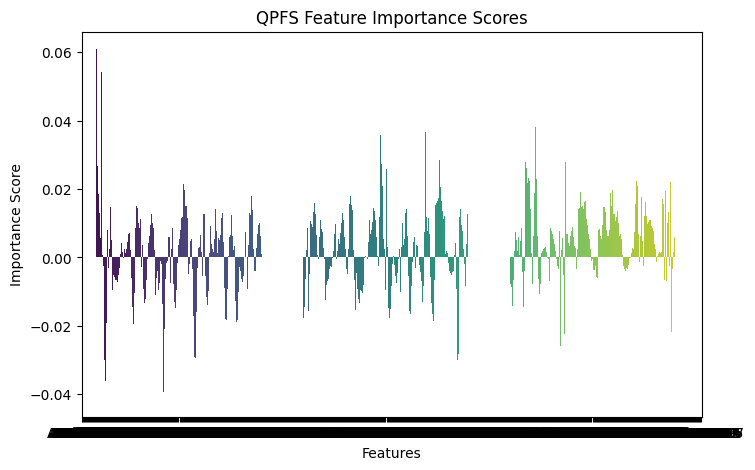

In [ ]:
# Visualize feature importance
plt.figure(figsize=(8,5))
sns.barplot(x=X.columns, y=x, palette="viridis")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("QPFS Feature Importance Scores")
plt.show()


<ipython-input-46-d1796ee7e069>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features_df, palette="viridis")


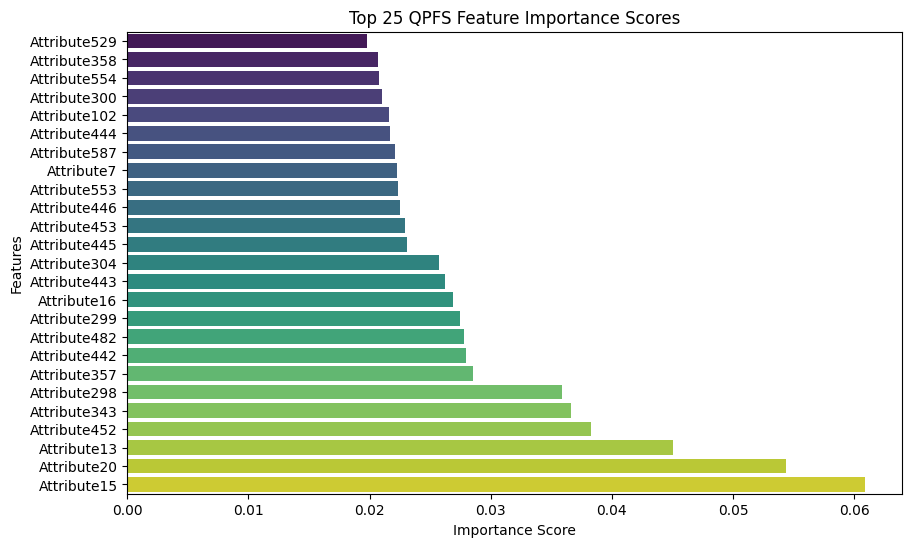

In [ ]:
# Lets select the 25 most important features and draw their importance score

top_features_indices = np.argsort(x)[-25:]
# Create a DataFrame with top features and their importance scores
top_features_df = pd.DataFrame({'Feature': X.columns[top_features_indices], 'Importance': x[top_features_indices]})

# Visualize top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features_df, palette="viridis")
plt.title("Top 25 QPFS Feature Importance Scores")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

